In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import xgboost
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [86]:
# Adjacency generating functions
def make_adjacency(rf, X):
    leafIDs = rf.apply(X)
    n_samples, n_trees = leafIDs.shape
    max_leaf = leafIDs.max()
    # give each (tree, leaf) a unique global ID
    leafIDs_global = (leafIDs + np.arange(n_trees) * max_leaf).astype(int)

    # Build sparse membership matrix M
    row_ind = np.repeat(np.arange(n_samples), n_trees)
    col_ind = leafIDs_global.ravel()
    data = np.ones_like(row_ind, dtype=np.float32)

    M = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, col_ind.max() + 1))

    # leaf sizes and weights
    leaf_sizes = np.array(M.sum(axis=0)).ravel()
    leaf_weights = 1.0 / np.maximum(leaf_sizes, 1)  # avoid div by zero

    M_norm = M @ diags(leaf_weights)
    A = (M_norm @ M.T) / n_trees
    
    metadata = {
        "leaf_weights": leaf_weights,
        "leafIDs": leafIDs,
        'n_trees': n_trees,
        'max_leaf': max_leaf,
        'M_train': M
    }
    return A.toarray(), metadata

def new_adjacency(rf, X_new, metadata):
    M_train = metadata["M_train"]
    leaf_weights = metadata["leaf_weights"]
    n_trees = metadata["n_trees"]
    max_leaf = metadata["max_leaf"]
    
    n_new = X_new.shape[0]
    
    # Get terminal nodes for new data
    leafIDs_new = rf.apply(X_new)
    leafIDs_global_new = (leafIDs_new + np.arange(n_trees) * max_leaf).astype(int)
    
    # Merge train and new leaves
    leafIDs_global_train = M_train.indices
    leafIDs_union = np.union1d(leafIDs_global_train, leafIDs_global_new.ravel())
    
    # Map global IDs to columns
    id_map_train = {lid: i for i, lid in enumerate(leafIDs_union)}
    id_map_new = {lid: i for i, lid in enumerate(leafIDs_union)}
    
    # Sparse matrices
    row_ind_train = np.repeat(np.arange(M_train.shape[0]), n_trees)
    col_ind_train = np.array([id_map_train[lid] for lid in M_train.indices])
    M_train_sparse = csr_matrix((np.ones_like(row_ind_train), 
                                 (row_ind_train, col_ind_train)),
                                shape=(M_train.shape[0], len(leafIDs_union)))
    
    row_ind_new = np.repeat(np.arange(n_new), n_trees)
    col_ind_new = np.array([id_map_new[lid] for lid in leafIDs_global_new.ravel()])
    M_new_sparse = csr_matrix((np.ones_like(row_ind_new), 
                               (row_ind_new, col_ind_new)),
                              shape=(n_new, len(leafIDs_union)))
    
    # Normalize new matrix
    leaf_sizes = np.array(M_train_sparse.sum(axis=0)).ravel()
    leaf_weights = 1.0 / leaf_sizes
    leaf_weights[~np.isfinite(leaf_weights)] = 0
    M_new_norm = M_new_sparse @ diags(leaf_weights)
    
    # Weighted adjacency for new data vs training
    A_new = (M_train_sparse @ M_new_norm.T).T / n_trees
    return A_new.toarray()

In [61]:
data = pd.read_csv('data_42.csv', index_col=0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)
skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_val)

# access trees
# trees = skrf.estimators_
A, metadata = make_adjacency(skrf, X_train)
A_new = new_adjacency(skrf, X_val, metadata)
D = 1-A

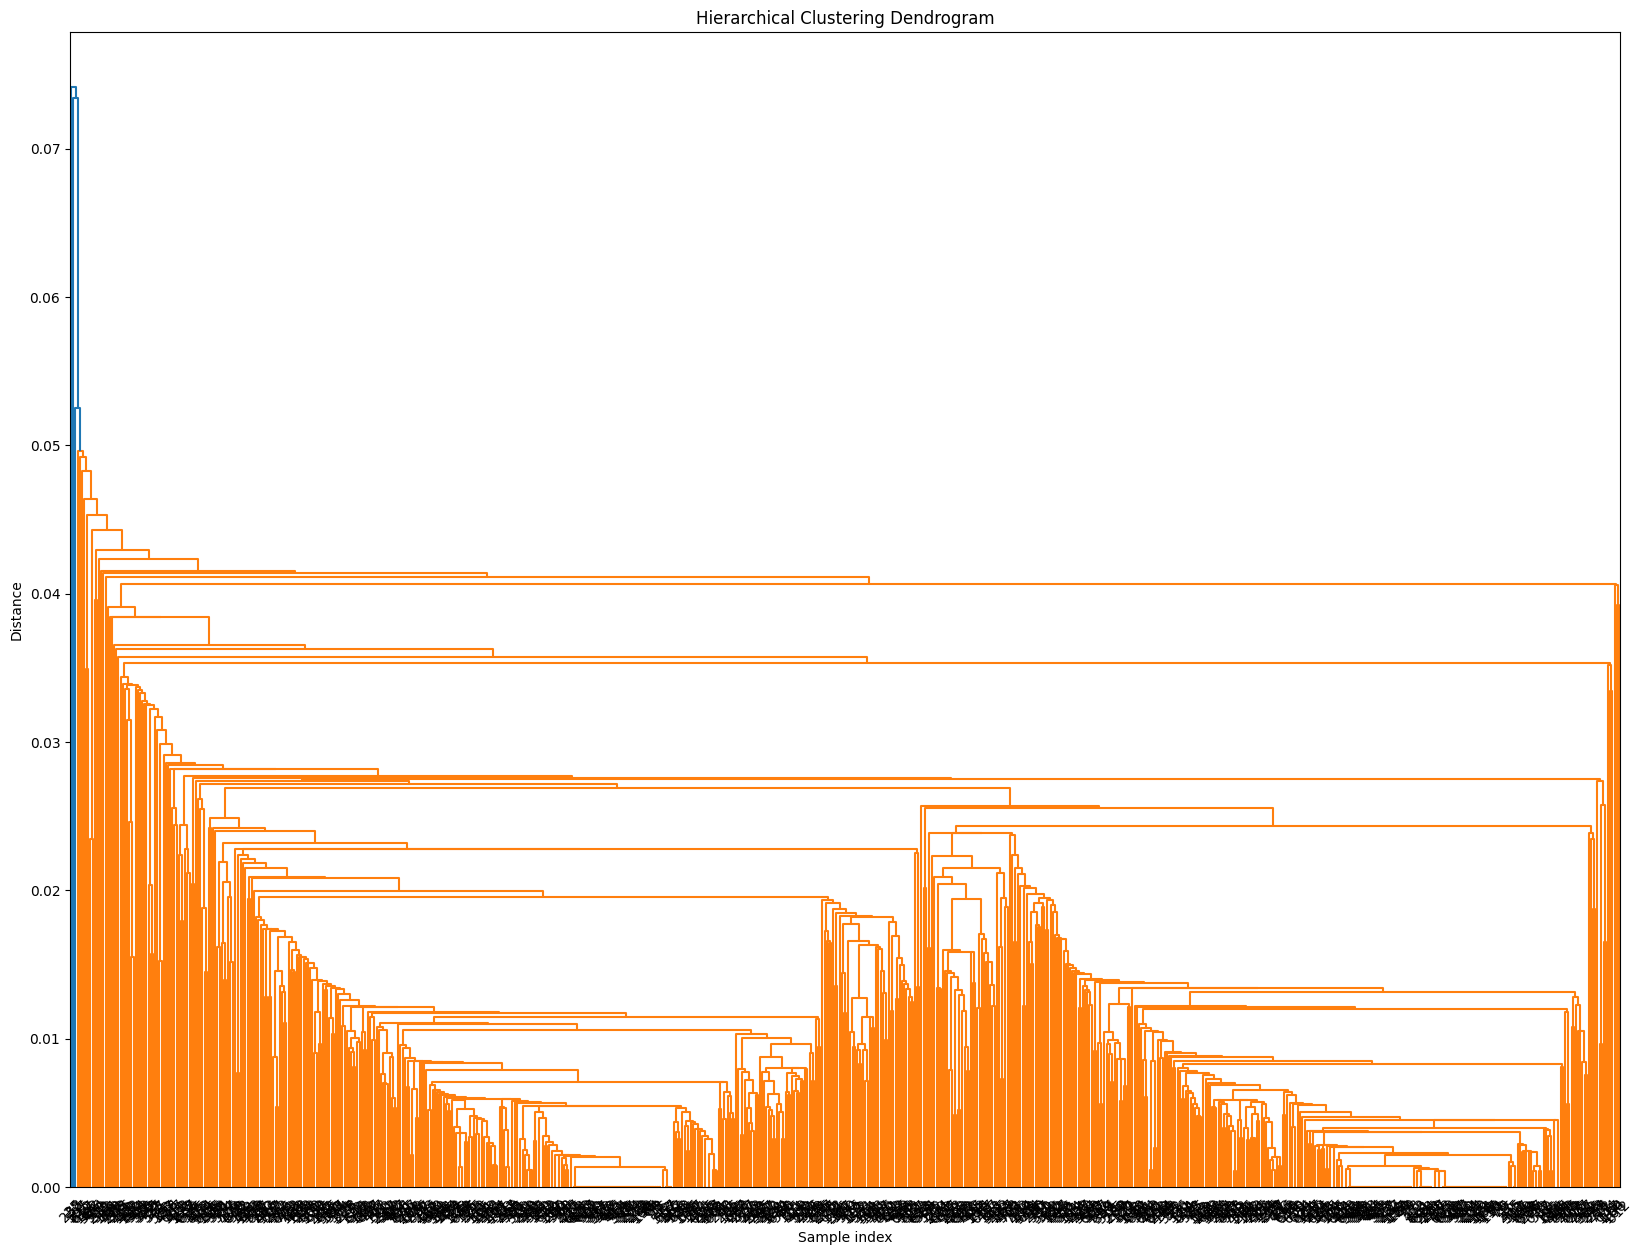

In [70]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

Z = linkage(D, method = 'single')
plt.figure(figsize=(20, 15))
dendrogram(Z, truncate_mode=None, leaf_rotation=45, leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [88]:

rootnode, nodelist = to_tree(Z, rd=True)

In [89]:
rootnode.id

1438

In [90]:
class DDT(nn.Module):
    def __init__(self, input_dim, root, nodes, output_dim, use_cuda=False):
        super(DDT, self).__init__()
        self.root = root
        self.nodes = {node.id: node for node in nodes}
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.device = torch.device("cuda" if use_cuda else "cpu")

        self.internal_node_num_ = self.output_dim - 1
        self.leaf_node_num_ = self.output_dim        

        self.inner_nodes = nn.Sequential(
            nn.Linear(self.input_dim + 1, self.internal_node_num_, bias=False),
            nn.Sigmoid(),
            nn.Linear(self.internal_node_num_, self.output_dim, bias=False)
        )

        self.split_layers = nn.ModuleDict()
        for nid, node in self.nodes.items():
            if node.left is not None and node.right is not None:
                self.split_layers[str(nid)] = nn.Sequential(
                    nn.Linear(input_dim + 1, 1, bias = False),
                    nn.Sigmoid()
                )
    def forward(self, X):
        X = self._data_augment(X)
        batch_size = X.size(0)

        mu = {nid: torch.zeros(batch_size, 1, device=X.device)
              for nid in self.nodes}
        mu[self.root.id] = torch.ones(batch_size, 1, device = X.device)

        stack = [self.root.id]
        while stack:
            nid = stack.pop()
            node = self.nodes[nid]

            if node.left is None:
                continue
            
            p_left = self.split_layers[str(nid)](X)
            mu[node.left.id] += mu[nid] * p_left
            mu[node.right.id] += mu[nid] * (1 - p_left)

            stack.extend([node.left.id, node.right.id])

        leaf_probs = [mu[nid] for nid, node in self.nodes.items() if node.left is None]
        leaf_probs = torch.cat(leaf_probs, dim=1)

        top_probs, top_idx = torch.topk(leaf_probs, k=50, dim=1)
        mask = torch.zeros_like(leaf_probs)
        mask.scatter_(1, top_idx, 1.0)
        leaf_probs = leaf_probs * mask
        leaf_probs = leaf_probs / (leaf_probs.sum(dim=1, keepdim=True))
        

        return leaf_probs
    def _data_augment(self, X):
        """add bias feature as leading 1."""
        batch_size = X.size(0)
        X = X.view(batch_size, -1)
        bias = torch.ones(batch_size, 1, device=self.device)
        return torch.cat((bias, X), dim=1)
class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        X: DataFrame (features)
        y: numpy array (labels)
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [91]:
input_dim = 10
output_dim = X_train.shape[0]
lr = 1e-3
batch_size = 50
epochs = 50
log_interval = 50
use_cuda = False
weight_decay = 5e-4


In [92]:
tree = DDT(input_dim, rootnode, nodelist, output_dim, use_cuda)
optimizer = torch.optim.Adam(tree.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

In [93]:
train_dataset = TabularDataset(X_train, A)
val_dataset = TabularDataset(X_val, A_new)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [94]:
best_testing_acc = 0.0
val_acc_list = []
training_loss_list = []
criterion = nn.KLDivLoss(reduction='batchmean')
#criterion = nn.MSELoss()
device = torch.device("cuda" if use_cuda else "cpu")

for epoch in range(epochs):
    tree.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        output = tree.forward(data)
        output = torch.log(output + 1e-8)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f}"
            )
            print(msg.format(epoch, batch_idx, loss.item()))
            training_loss_list.append(loss.cpu().item())

    tree.eval()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = tree.forward(data)
            output = torch.log(output + 1e-8)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    print(f"\nEpoch {epoch:02d} | Testing Avg Loss: {avg_loss:.5f}\n")
    val_acc_list.append(avg_loss)            

Epoch: 00 | Batch: 000 | Loss: 12.22493

Epoch 00 | Testing Avg Loss: 12.21109

Epoch: 01 | Batch: 000 | Loss: 12.16282

Epoch 01 | Testing Avg Loss: 12.20119

Epoch: 02 | Batch: 000 | Loss: 12.16816

Epoch 02 | Testing Avg Loss: 12.19140

Epoch: 03 | Batch: 000 | Loss: 12.16371

Epoch 03 | Testing Avg Loss: 12.18098

Epoch: 04 | Batch: 000 | Loss: 12.17336

Epoch 04 | Testing Avg Loss: 12.16706

Epoch: 05 | Batch: 000 | Loss: 12.17005

Epoch 05 | Testing Avg Loss: 12.14691

Epoch: 06 | Batch: 000 | Loss: 12.17485

Epoch 06 | Testing Avg Loss: 12.12345

Epoch: 07 | Batch: 000 | Loss: 12.11863

Epoch 07 | Testing Avg Loss: 12.10129

Epoch: 08 | Batch: 000 | Loss: 12.09255

Epoch 08 | Testing Avg Loss: 12.08241

Epoch: 09 | Batch: 000 | Loss: 12.06891

Epoch 09 | Testing Avg Loss: 12.06794

Epoch: 10 | Batch: 000 | Loss: 12.06744

Epoch 10 | Testing Avg Loss: 12.05496

Epoch: 11 | Batch: 000 | Loss: 12.01212

Epoch 11 | Testing Avg Loss: 12.04388

Epoch: 12 | Batch: 000 | Loss: 12.03251


In [95]:
X_val.shape

(80, 10)

In [78]:
new_leaves = skrf.apply(X_test)
A_new = new_adjacency(new_leaves, metadata)

TypeError: new_adjacency() missing 1 required positional argument: 'metadata'

In [96]:
X_test = test_loader.dataset[:][0]
y_test = test_loader.dataset[:][1]
X_test = X_test.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    output = tree(X_test)
    log_output = torch.log(output + 1e-8)
    total_loss = criterion(output, y_test).item()

NameError: name 'test_loader' is not defined

In [61]:
total_loss

-0.12150001525878906

In [64]:
sum(output[0, ])

tensor(1.)

In [67]:
sum(sum(target))

tensor(0.3603)

In [68]:
target.shape

torch.Size([30, 720])

In [66]:
target

tensor([[3.8121e-07, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.5340e-05],
        [4.1271e-06, 1.9666e-05, 1.2757e-05,  ..., 1.7725e-05, 9.6485e-06,
         0.0000e+00],
        [3.8121e-07, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.9721e-05],
        ...,
        [2.5376e-05, 1.4775e-05, 4.8920e-05,  ..., 1.3492e-05, 4.3065e-05,
         0.0000e+00],
        [2.9103e-06, 6.2666e-06, 6.0569e-06,  ..., 5.4570e-06, 3.9740e-06,
         0.0000e+00],
        [1.7412e-05, 9.7975e-06, 1.0725e-05,  ..., 9.1908e-06, 7.5053e-06,
         0.0000e+00]])